In [4]:
import matplotlib.font_manager
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random 
import csv
from IPython.display import display, Math
from numpy import unravel_index
from scipy.optimize import curve_fit

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

plt.rcParams["font.family"] = "TeX Gyre Schola Math"

print("Raw Transverse Velocities")

Raw Transverse Velocities


## Import the data

### Importing the data from Gaia

In [5]:
def OutCVSGaia(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3, LIST4, LIST5, LIST6, LIST7 = [], [], [], [], [], [], []
    with open('ThisIsTheData/' + name + '.csv', 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            LIST1.append(float(row[0])) #x position
            LIST2.append(float(row[1])) #y position
            LIST3.append(float(row[2])) #pmra
            LIST4.append(float(row[3])) #sigma on the pmra
            LIST5.append(float(row[4])) #pmdec
            LIST6.append(float(row[5])) #sigma on the pmdec
            LIST7.append(float(row[6])) #pmra and pmdec correlations
            
    return LIST1, LIST2, LIST3, LIST4, LIST5, LIST6, LIST7

In [6]:
#We first import all the position of the different stars
x_All, y_All, pmra_All, pmra_sig_All, pmdec_All, pmdec_sig_All, pm_corr_All        = OutCVSGaia('AllStars')
x_Blue, y_Blue, pmra_Blue, pmra_sig_Blue, pmdec_Blue, pmdec_sig_Blue, pm_corr_Blue = OutCVSGaia('BlueStars')
x_Red, y_Red, pmra_Red, pmra_sig_Red, pmdec_Red, pmdec_sig_Red, pm_corr_Red        = OutCVSGaia('RedStars')

### Organising the data from the Gaia data

In [49]:
def OrganiseGaiaData(x, y, pmra, pmra_e, pmdec, pmdec_e, pm_corr):
    #___ Description_____________________________________________________________________________________
    #Arguments:: gives all the relevant quantities
    #Returns:: list with all the different significant quantities localised in it
    #____________________________________________________________________________________________________
     
    GaiaData = []
    
    GaiaData.append(x)
    GaiaData.append(y)
    GaiaData.append(pmra)
    GaiaData.append(pmra_e)
    GaiaData.append(pmdec)
    GaiaData.append(pmdec_e)
    GaiaData.append(pm_corr)
    
    return GaiaData

In [50]:
GaiaDataAll  = OrganiseGaiaData(x_All, y_All, pmra_All, pmra_sig_All, pmdec_All, pmdec_sig_All, pm_corr_All)
GaiaDataBlue = OrganiseGaiaData(x_Blue, y_Blue, pmra_Blue, pmra_sig_Blue, pmdec_Blue, pmdec_sig_Blue, pm_corr_Blue)
GaiaDataRed  = OrganiseGaiaData(x_Red, y_Red, pmra_Red, pmra_sig_Red, pmdec_Red, pmdec_sig_Red, pm_corr_Red)

### Importing the data from the model

In [51]:
def OutCVSModel(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3 = [], [], []
    if name != "model":
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append([float(row[0]), float(row[1])])
        return LIST1
    
    else:
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append(float(row[0]))
                LIST2.append(float(row[1]))
                LIST3.append(-float(row[2]))
        return LIST1, LIST2, LIST3        

In [52]:
#Reading the cvs files
xb = OutCVSModel('x_edges') #all x the edges of the bins
yb = OutCVSModel('y_edges') #all the y edges of the bins
vb = OutCVSModel('vel')     #all the heliocentric velocities of the bins

x_model, y_model, z_model = OutCVSModel("model")

## Superimposing the model with the data 

We will first do a sort of visual check to see if the model we have and the data coming from gaia actually do match, and as we can see below, they seem to match pretty well. Noice.

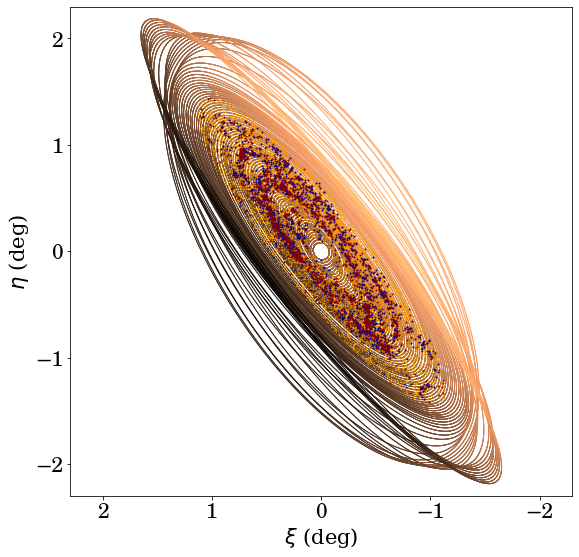

In [53]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)

#Plot of the stars coming from gaia
plt.scatter(x_All, y_All, s=0.1, color='orange')
plt.scatter(x_Blue, y_Blue, s=0.9, color='darkblue')
plt.scatter(x_Red, y_Red, s=0.9, color='darkred')

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

## Velocity of the stars from Gaia

In this section we will create a function that will allow us to know in which bin a star is located and hence go back to the velocity with which it should be observed based on the rotation model (in the heliocentric frame).

In [54]:
def FindBin(x, y, x_intervals, y_intervals, vel):
    #___ Description_____________________________________________________________________________________
    #Arguments:: coordinates of the point, lists of the intervals (along x and y) and the list of the 
    #           components of the velocity along each axis
    #Returns:: returns the components of the velocity in the bin in mas/yr
    #____________________________________________________________________________________________________
     
    #We first determine in which bin the point/star is located
    count = 0
    for i in range(len(x_intervals)):
        if x > x_intervals[i][0] and x < x_intervals[i][1]:
            if y > y_intervals[i][0] and y < y_intervals[i][1]:
                count = i    
                
    #Let's convert the velocity from km/s to mas/yr
    RadDist = 780*3.08E16 #Radial distance from M31 in km
    YrToSec = 365.25*86400 #Years to seconds
    
    pm_ra  = ((vel[count][0]*YrToSec)/(RadDist*4.84814E-9))
    pm_dec = (vel[count][1]*YrToSec)/(RadDist*4.84814E-9)

    return pm_ra, pm_dec

### Organising the data from the model

In [55]:
def OrganiseModelData(x_stars, y_stars, x_bounds, y_bounds, vel):
    #___ Description_____________________________________________________________________________________
    #Arguments:: 'x' and 'y_stars' are lists of the coordinates of the star for which we want the proper
    #           motion. 'x' and 'y_bounds' are the limits of the bins of the model and 'vel' the 
    #           velocities associated in each of those
    #Returns:: returns a list with all the proper motions of the stars in mas/yr
    #____________________________________________________________________________________________________

    ModelData = [[], []]
        
    for i in range(len(x_stars)):
        Temporary = FindBin(x_stars[i], y_stars[i], xb, yb, vb)
        ModelData[0].append(Temporary[0])
        ModelData[1].append(Temporary[1])
    
    return ModelData

In [56]:
ModelDataAll  = OrganiseModelData(GaiaDataAll[0], GaiaDataAll[1], xb, yb, vb)
ModelDataBlue = OrganiseModelData(GaiaDataBlue[0], GaiaDataBlue[1], xb, yb, vb)
ModelDataRed  = OrganiseModelData(GaiaDataRed[0], GaiaDataRed[1], xb, yb, vb)

#### Let's quickly visualise if this worked by superimposing the velocities from the model that we gave to the stars of the Gaia data

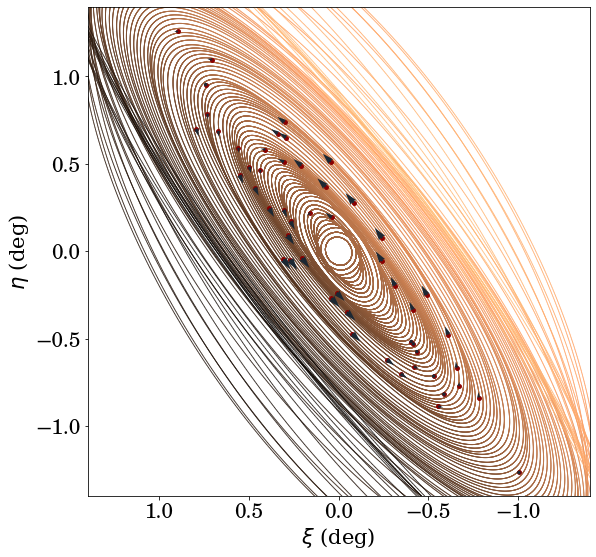

In [41]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)

for i in range(len(x_Red)):
    if i % 2 == 0 and i % 3 == 0 and i %5 == 0:
        plt.scatter(x_Red[i], y_Red[i], s=15, color='darkred')
        plt.quiver(x_Red[i], y_Red[i], ModelDataRed[0][i], ModelDataRed[1][i], angles='xy', scale_units='xy', scale=1, color='#1c2833') 
                
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-1.4, 1.4)
plt.ylim(-1.4, 1.4)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('42.png', dpi=150)
plt.show()

#### Now let's visualise the data coming directly from gaia

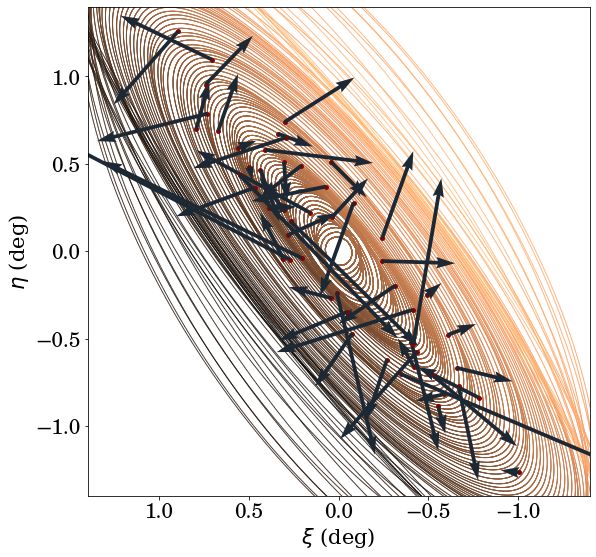

In [42]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)

for i in range(len(x_Red)):
    if i % 2 == 0 and i % 3 == 0 and i %5 == 0:
        plt.scatter(x_Red[i], y_Red[i], s=15, color='darkred')
        plt.quiver(x_Red[i], y_Red[i], GaiaDataRed[2][i], GaiaDataRed[4][i], angles='xy', scale_units='xy', scale=1, color='#1c2833') 
                
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-1.4, 1.4)
plt.ylim(-1.4, 1.4)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('42.png', dpi=150)
plt.show()

## Mock data

In [15]:
def MockData(GaiaData, ModelData):
    vel_ra, vel_dec = [], []
    
    #Modelling the bulk motion
    random_ra_bulk  = [0]  #It's 0, so not so random
    random_dec_bulk = [0]
        
    #Modelling the error on the proper motion
    for i in range(len(GaiaData[0])):
        random_ra_error  = np.random.normal(0, GaiaData[3], 1)
        random_dec_error = np.random.normal(0, GaiaData[5], 1)

        vel_ra.append(ModelData[0][i] + random_ra_bulk[0] + random_ra_error[0]) 
        vel_dec.append(ModelData[1][i] + random_dec_bulk[0] + random_dec_error[0])
        
    return [vel_ra, vel_dec]

## Determination of the likelihood

In [34]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData, MockData, Colour):
        self.NbModels = NbModels
        self.Colour   = Colour
        
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]  
        
        if len(MockData) != 0:
            self.mu_ra_gaia  = MockData[0]
            self.mu_dec_gaia = MockData[1]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_dec_M31), len(self.pm_ra_M31)))
        for i in range(len(self.pm_dec_M31)):
            for j in range(len(self.pm_ra_M31)):
                for k in range(len(self.mu_ra_gaia)):
                    self.LikelihoodList[j,i] += self.LikelihoodSingleStar(k, i, j)

        self.Renormalisation()  
        
        return self.ra_max, self.dec_max
                
    def FreeParameters(self):
        #self.pm_ra_M31  = np.linspace(0.013, 0.081, self.NbModels) #from 50km/s to 300km/s
        #self.pm_dec_M31 = np.linspace(0, -0.095, self.NbModels) #from 0km/s to -350km/s
        #self.pm_ra_M31  = np.linspace(0, 0.3, self.NbModels) 
        #self.pm_dec_M31 = np.linspace(-0.1, 0.3, self.NbModels)
        self.pm_ra_M31  = np.linspace(-0.2, 0.2, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.2, 0.2, self.NbModels)
        #self.pm_ra_M31  = np.linspace(-0.05, 0.05, self.NbModels) 
        #self.pm_dec_M31 = np.linspace(-0.05, 0.05, self.NbModels)
        
    def LikelihoodSingleStar(self, index_star, index_model_ra, index_model_dec):
        GaussianCenter_ra  = self.pm_ra_M31[index_model_ra] + self.mu_ra_model[index_star]
        GaussianCenter_dec = self.pm_dec_M31[index_model_dec] + self.mu_dec_model[index_star]

        PreFactor = 1/(2*np.pi*self.mu_ra_sig_gaia[index_star]*self.mu_dec_sig_gaia[index_star])    
        ExpRa  = -0.5*((self.mu_ra_gaia[index_star] - GaussianCenter_ra)/(self.mu_ra_sig_gaia[index_star]))**2
        ExpDec = -0.5*((self.mu_dec_gaia[index_star] - GaussianCenter_dec)/(self.mu_dec_sig_gaia[index_star]))**2
        
        return np.log(PreFactor) + ExpRa + ExpDec #exp to come back to the L and not ln(L)
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_ra_M31)):
            for j in range(len(self.pm_dec_M31)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_dec_M31[dec_max], self.pm_ra_M31[ra_max]
             
    def PrintPlot(self):
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 2)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 2)) + r"\ \mu as/yr"))
        
        #Plot of the contours:
        plt.figure(figsize=(8, 8))
        plt.contourf(self.pm_ra_M31, self.pm_dec_M31, self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)], 
                    cmap=self.Colour) #values for the levels taken from the book "Numerical Recipes" and corresponding to 1, 2, 3 sigmas
        plt.scatter(self.ra_max, self.dec_max, c="#f6b515")
        plt.xticks(fontsize=15)
        plt.yticks(fontsize = 15)
        plt.xlabel(r'$\mu_{\alpha, M31}$ (mas.yr$^{-1})$', fontname = 'Serif', size = 19)
        plt.ylabel(r'$\mu_{\delta, M31}$ (mas.yr$^{-1})$', fontname = 'Serif', size = 19)
        plt.gca().invert_xaxis()
        plt.show()

### Let's make a loop in order to determine the typical errors on the recovering of the proper motion

This step is made in order to see if we have systematics in our results. For the first series of tests give a velocity of 0 in both directions to M31 and we want to recover this velocity. We explore a total domain of $\pm$50$\mu$as.yr$^{-1}$ in both $\alpha$ and $\delta$ directions and we will explore this domain using three different "densities of exploration". Now, the reader might ask himself what is meant by that. It is simply a way to quantify how many values are tested along each axis. The densities will be the following:

- 21 points per axis
- 42 points per axis
- 99 points per axis

In [35]:
class Statistics():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbTests, NbDensity):
        self.centre_ra, self.centre_dec = [], []
        
        self.NbTests   = NbTests
        self.NbDensity = NbDensity
        
    #____Methods::_______________________________________________________________________________________    
    def DoStatistics(self):
        for i in range(self.NbTests):
            Test    = MockData(GaiaDataBlue, ModelDataBlue)
            ObjLike = LikelihooD(self.NbDensity, GaiaDataBlue, ModelDataBlue, Test, "RdGy")
            Answer  = ObjLike.Execute()

            self.centre_ra.append(Answer[0]*1000)
            self.centre_dec.append(Answer[1]*1000) #the *1000 is here to transform the mas into µas
            
        self.RecoveredVelocities()    
        self.PlotHisto()
        self.PrintStatistics()
            
    def RecoveredVelocities(self):
        with open('ThisIsTheData/TestStatistics/' + str(self.NbTests) + "_models_" + str(self.NbDensity) + 
                  '.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            for i in range(len(self.centre_ra)):
                writer.writerow([self.centre_ra[i], self.centre_dec[i]])   
                
    def PlotHisto(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6.5))
        
        n, bins, patches = ax1.hist(self.centre_ra, bins=np.linspace(np.min(self.centre_ra), 
                                    np.max(self.centre_ra), self.NbDensity*2), color='blue', alpha=0.9)

        # Set the color of each bar based on its height
        for i in range(len(patches)):
            patches[i].set_fc(plt.cm.copper(n[i]/max(n)))
        
        ax1.set_xlabel(r'Deviation from 0 along $\alpha$ in $\mu$as.yr$^{-1}$', fontname = 'Serif', size = 18)
        ax1.set_ylabel('Occurrences', fontname = 'Serif', size = 18)
        ax1.xaxis.set_tick_params(labelsize=18)
        ax1.yaxis.set_tick_params(labelsize=18)
        
        n, bins, patches = ax2.hist(self.centre_dec, bins=np.linspace(np.min(self.centre_dec),
                                    np.max(self.centre_dec), self.NbDensity*2), color='blue', alpha=0.9)

        # Set the color of each bar based on its height
        for i in range(len(patches)):
            patches[i].set_fc(plt.cm.copper(n[i]/max(n)))
        
        ax2.set_xlabel(r'Deviation from 0 along $\delta$ in $\mu$as.yr$^{-1}$', fontname = 'Serif', size = 18)
        ax2.set_ylabel('Occurrences', fontname = 'Serif', size = 18)
        ax2.xaxis.set_tick_params(labelsize=18)
        ax2.yaxis.set_tick_params(labelsize=18)
        
        plt.show()
        
    def PrintStatistics(self):
        ra_mean     = np.mean(self.centre_ra)
        dec_mean    = np.mean(self.centre_dec)
        ra_std_dev  = np.std(self.centre_ra, ddof=0)
        dec_std_dev = np.std(self.centre_dec, ddof=0)

        display(Math(r"(\mu_{\alpha, M31}, \mu_{\delta, M31} ) = (" + str(round(ra_mean, 2)) + "\pm" +
                     str(round(ra_std_dev, 2)) + "," + str(round(dec_mean, 2)) + "\pm" +
                     str(round(dec_std_dev, 2)) + r")\ \mu as.yr^{-1}"))

In [ ]:
choice = input("Are you sure you want to lauch the program, this might take a while? (Yes/No): ")

if choice == "Yes":
    ObjStat = Statistics(1000, 21)
    ObjStat.DoStatistics()
    
    ObjStat = Statistics(1000, 42)
    ObjStat.DoStatistics()
    
    ObjStat = Statistics(1000, 99)
    ObjStat.DoStatistics()

## Mock data but not centred on 0

In [ ]:
def MockData(GaiaData, ModelData):
    vel_ra, vel_dec = [], []
    
    #Modelling the bulk motion
    random_ra_bulk  = [0.043]
    random_dec_bulk = [-0.028]
        
    #Modelling the error on the proper motion
    for i in range(len(GaiaData[0])):
        random_ra_error  = np.random.normal(0, GaiaData[3], 1)
        random_dec_error = np.random.normal(0, GaiaData[5], 1)

        vel_ra.append(ModelData[0][i] + random_ra_bulk[0] + random_ra_error[0]) 
        vel_dec.append(ModelData[1][i] + random_dec_bulk[0] + random_dec_error[0])
        
    return [vel_ra, vel_dec]

In [ ]:
Test    = MockData(GaiaDataBlue, ModelDataBlue)
ObjLike = LikelihooD(42, GaiaDataBlue, ModelDataBlue, Test, "RdGy")
Answer  = ObjLike.Execute()

In [ ]:
ObjLike.PrintPlot()

In [ ]:
choice = input("Are you sure you want to lauch the program, this might take a while? (Yes/No): ")

if choice == "Yes":
    ObjStat = Statistics(500, 84)
    ObjStat.DoStatistics()

## Apply the method to the data

In [36]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData, MockData):
        self.NbModels = NbModels
    
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]
        
        if len(MockData) != 0:
            self.mu_ra_gaia  = MockData[0]
            self.mu_dec_gaia = MockData[1]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_dec_M31), len(self.pm_ra_M31)))
        for i in range(len(self.pm_dec_M31)):
            for j in range(len(self.pm_ra_M31)):
                for k in range(len(self.mu_ra_gaia)):
                    self.LikelihoodList[j,i] += self.LikelihoodSingleStar(k, i, j)

        self.Renormalisation()  
        
        self.OneDimGaussian()
        
        return self.ra_max, self.dec_max
                
    def FreeParameters(self):
        #self.pm_ra_M31  = np.linspace(-0.1, 0.1, self.NbModels) 
        #self.pm_dec_M31 = np.linspace(-0.1, 0.1, self.NbModels)

        self.pm_ra_M31  = np.linspace(0., 0.1, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.1, 0., self.NbModels)
        
        self.space = (self.pm_ra_M31[-1] - self.pm_ra_M31[-2])
        
    def LikelihoodSingleStar(self, index_star, index_model_ra, index_model_dec):
        GaussianCenter_ra  = self.pm_ra_M31[index_model_ra] + self.mu_ra_model[index_star]
        GaussianCenter_dec = self.pm_dec_M31[index_model_dec] + self.mu_dec_model[index_star]

        PreFactor = 1/(2*np.pi*self.mu_ra_sig_gaia[index_star]*self.mu_dec_sig_gaia[index_star])    
        ExpRa  = -0.5*((self.mu_ra_gaia[index_star] - GaussianCenter_ra)/(self.mu_ra_sig_gaia[index_star]))**2
        ExpDec = -0.5*((self.mu_dec_gaia[index_star] - GaussianCenter_dec)/(self.mu_dec_sig_gaia[index_star]))**2
        
        return np.log(PreFactor) + ExpRa + ExpDec #exp to come back to the L and not ln(L)
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_ra_M31)):
            for j in range(len(self.pm_dec_M31)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_M31[dec_max], self.pm_dec_M31[ra_max]
             
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
             
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelleft=False, labelsize=0, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=0, labelbottom=False)
                       
            ax.contour([x * 1000 for x in self.pm_ra_M31], [x * 1000 for x in self.pm_dec_M31], self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#ff6200', 'darkred', 'black'])
            ax.scatter(self.ra_max*1000, self.dec_max*1000, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_M31)):
                self.x_bins.append(self.pm_ra_M31[i] - self.space/2)
            for i in range(len(self.pm_ra_M31)):
                self.y_bins.append(self.pm_dec_M31[i] - self.space/2)

            #Plot of the RA histogram
            colors = self.y_gaus / np.max(self.y_gaus)
            ax_histx.bar([x * 1000 for x in self.x_bins], self.y_gaus, width=self.space*1000, align='edge', 
                         edgecolor='black', color='darkred', alpha=0.7)
            ax_histx.set_yticklabels([])
            self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            colors = self.x_gaus / np.max(self.x_gaus)
            ax_histy.barh([x * 1000 for x in self.y_bins], self.x_gaus, height=self.space*1000, align='edge', 
                          edgecolor='black', color='darkblue', alpha=0.7)
            ax_histy.set_xticklabels([])
            self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(8, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 2)) + "\pm" + str(
            round(abs(self.popt_ra[2])*1000, 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 2)) + "\pm" + str(
            round(abs(self.popt_dec[2])*1000, 1))  + r"\ \mu as/yr"))

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

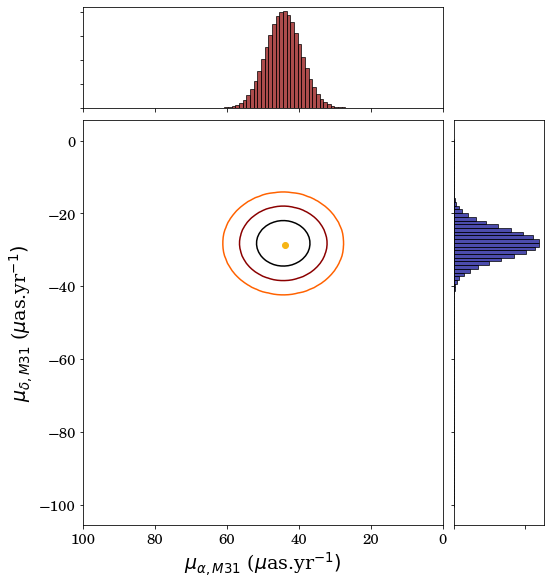

In [377]:
ObjLike = LikelihooD(99, GaiaDataBlue, ModelDataBlue, [])
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

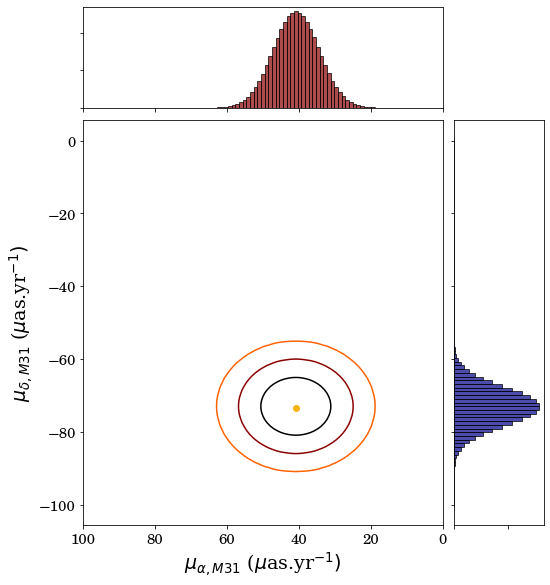

In [378]:
ObjLike = LikelihooD(99, GaiaDataRed, ModelDataRed, [])
ObjLike.Execute()
ObjLike.Plot()

# Taking into account the correlations

In [384]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData, MockData):
        self.NbModels = NbModels
    
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        self.corr             = GaiaData[6]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]
        
        if len(MockData) != 0:
            self.mu_ra_gaia  = MockData[0]
            self.mu_dec_gaia = MockData[1]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_dec_M31), len(self.pm_ra_M31)))
        for i in range(len(self.pm_dec_M31)):
            for j in range(len(self.pm_ra_M31)):
                for k in range(len(self.mu_ra_gaia)):
                    self.LikelihoodList[j,i] += self.LikelihoodSingleStar(k, i, j)

        self.Renormalisation()  
        
        self.OneDimGaussian()
        
        return self.ra_max, self.dec_max
                
    def FreeParameters(self):
        #self.pm_ra_M31  = np.linspace(-0.1, 0.1, self.NbModels) 
        #self.pm_dec_M31 = np.linspace(-0.1, 0.1, self.NbModels)

        self.pm_ra_M31  = np.linspace(0., 0.1, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.1, 0., self.NbModels)
        
        self.space = (self.pm_ra_M31[-1] - self.pm_ra_M31[-2])
        
    def LikelihoodSingleStar(self, index_star, index_model_ra, index_model_dec):
        GaussianCenter_ra  = self.pm_ra_M31[index_model_ra] + self.mu_ra_model[index_star]
        GaussianCenter_dec = self.pm_dec_M31[index_model_dec] + self.mu_dec_model[index_star]

        PreFactor = 1/(2*np.pi*self.mu_ra_sig_gaia[index_star]*self.mu_dec_sig_gaia[index_star]*np.sqrt(1 - self.corr[index_star]**2))    
        ExpRa  = -(1/(2*(1 - self.corr[index_star]**2)))*((self.mu_ra_gaia[index_star] - GaussianCenter_ra
                                                          )/(self.mu_ra_sig_gaia[index_star]))**2
        ExpDec = -(1/(2*(1 - self.corr[index_star]**2)))*((self.mu_dec_gaia[index_star] - GaussianCenter_dec
                                                          )/(self.mu_dec_sig_gaia[index_star]))**2
        ExpCor = (1/(2*(1 - self.corr[index_star]**2)))*((2*self.corr[index_star]*(
                                                           self.mu_ra_gaia[index_star] - GaussianCenter_ra)*(
                                                           self.mu_dec_gaia[index_star] - GaussianCenter_dec))/(
                                                           self.mu_ra_sig_gaia[index_star]*self.mu_dec_sig_gaia[index_star]))
        
        return np.log(PreFactor) + ExpRa + ExpDec + ExpCor #exp to come back to the L and not ln(L)
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_ra_M31)):
            for j in range(len(self.pm_dec_M31)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_M31[dec_max], self.pm_dec_M31[ra_max]
             
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
             
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelleft=False, labelsize=0, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=0, labelbottom=False)
                       
            ax.contour([x * 1000 for x in self.pm_ra_M31], [x * 1000 for x in self.pm_dec_M31], self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#ff6200', 'darkred', 'black'])
            ax.scatter(self.ra_max*1000, self.dec_max*1000, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_M31)):
                self.x_bins.append(self.pm_ra_M31[i] - self.space/2)
            for i in range(len(self.pm_ra_M31)):
                self.y_bins.append(self.pm_dec_M31[i] - self.space/2)

            #Plot of the RA histogram
            colors = self.y_gaus / np.max(self.y_gaus)
            ax_histx.bar([x * 1000 for x in self.x_bins], self.y_gaus, width=self.space*1000, align='edge', 
                         edgecolor='black', color='darkred', alpha=0.7)
            ax_histx.set_yticklabels([])
            self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            colors = self.x_gaus / np.max(self.x_gaus)
            ax_histy.barh([x * 1000 for x in self.y_bins], self.x_gaus, height=self.space*1000, align='edge', 
                          edgecolor='black', color='darkblue', alpha=0.7)
            ax_histy.set_xticklabels([])
            self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(8, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 2)) + "\pm" + str(
            round(abs(self.popt_ra[2])*1000, 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 2)) + "\pm" + str(
            round(abs(self.popt_dec[2])*1000, 1))  + r"\ \mu as/yr"))

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

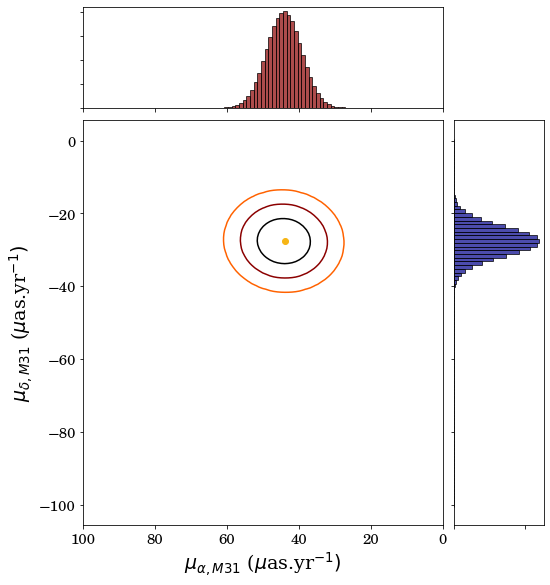

In [385]:
ObjLike = LikelihooD(99, GaiaDataBlue, ModelDataBlue, [])
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

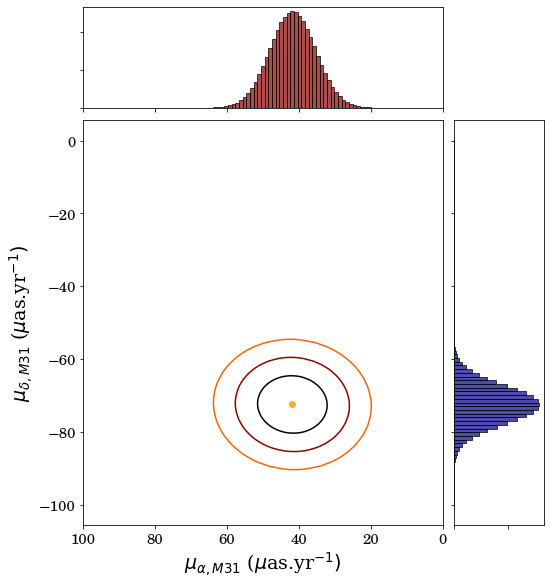

In [386]:
ObjLike = LikelihooD(99, GaiaDataRed, ModelDataRed, [])
ObjLike.Execute()
ObjLike.Plot()

# Use Cython to accelerate the program

## Without the correlations

In [24]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData, MockData):
        self.NbModels = NbModels
    
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]
        
        if len(MockData) != 0:
            self.mu_ra_gaia  = MockData[0]
            self.mu_dec_gaia = MockData[1]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_dec_M31), len(self.pm_ra_M31)))
        for i in range(len(self.pm_dec_M31)):
            for j in range(len(self.pm_ra_M31)):
                for k in range(len(self.mu_ra_gaia)):
                    self.LikelihoodList[j,i] += LikelihoodCFunction(self.pm_ra_M31[i], self.pm_dec_M31[j], 
                                                                    self.mu_ra_model[k], self.mu_dec_model[k],
                                                                    self.mu_ra_sig_gaia[k], self.mu_dec_sig_gaia[k], 
                                                                    self.mu_ra_gaia[k], self.mu_dec_gaia[k])

        self.Renormalisation()  
        
        self.OneDimGaussian()
        
        return self.ra_max, self.dec_max
                
    def FreeParameters(self):
        self.pm_ra_M31  = np.linspace(0., 0.1, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.1, 0., self.NbModels)
        
        self.space = (self.pm_ra_M31[-1] - self.pm_ra_M31[-2])
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_ra_M31)):
            for j in range(len(self.pm_dec_M31)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_M31[dec_max], self.pm_dec_M31[ra_max]
             
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
             
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelleft=False, labelsize=0, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=0, labelbottom=False)
                       
            ax.contour([x * 1000 for x in self.pm_ra_M31], [x * 1000 for x in self.pm_dec_M31], self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#ff6200', 'darkred', 'black'])
            ax.scatter(self.ra_max*1000, self.dec_max*1000, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_M31)):
                self.x_bins.append(self.pm_ra_M31[i] - self.space/2)
            for i in range(len(self.pm_ra_M31)):
                self.y_bins.append(self.pm_dec_M31[i] - self.space/2)

            #Plot of the RA histogram
            colors = self.y_gaus / np.max(self.y_gaus)
            ax_histx.bar([x * 1000 for x in self.x_bins], self.y_gaus, width=self.space*1000, align='edge', 
                         edgecolor='black', color='darkred', alpha=0.7)
            ax_histx.set_yticklabels([])
            self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            colors = self.x_gaus / np.max(self.x_gaus)
            ax_histy.barh([x * 1000 for x in self.y_bins], self.x_gaus, height=self.space*1000, align='edge', 
                          edgecolor='black', color='darkblue', alpha=0.7)
            ax_histy.set_xticklabels([])
            self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(8, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 2)) + "\pm" + str(
            round(abs(self.popt_ra[2])*1000, 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 2)) + "\pm" + str(
            round(abs(self.popt_dec[2])*1000, 1))  + r"\ \mu as/yr"))

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

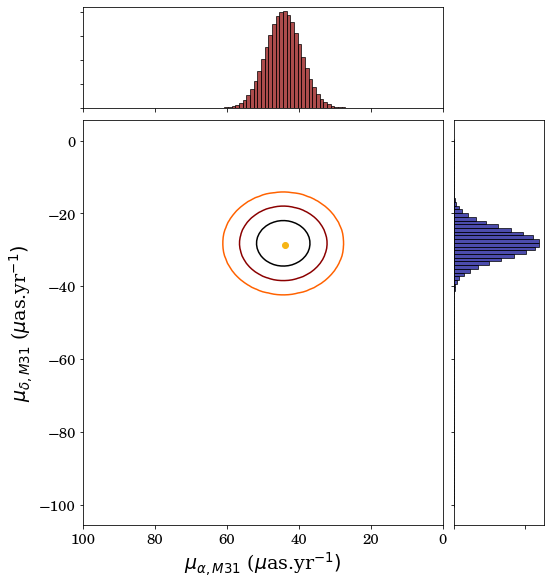

In [25]:
ObjLike = LikelihooD(99, GaiaDataBlue, ModelDataBlue, [])
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

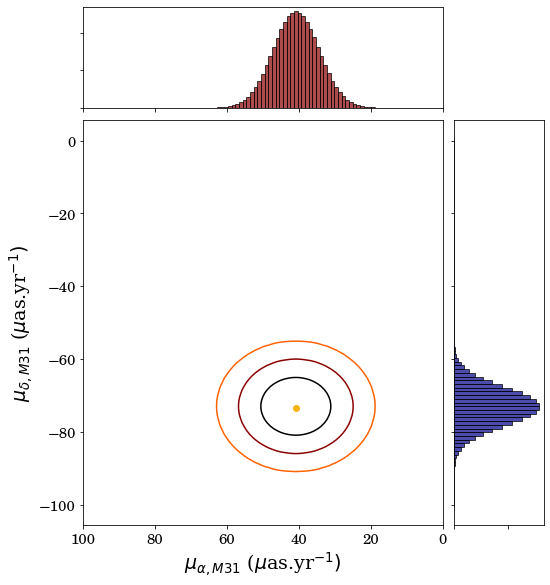

In [26]:
ObjLike = LikelihooD(99, GaiaDataRed, ModelDataRed, [])
ObjLike.Execute()
ObjLike.Plot()

## With the correlations

In [27]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData, MockData):
        self.NbModels = NbModels
    
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        self.corr             = GaiaData[6]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]
        
        if len(MockData) != 0:
            self.mu_ra_gaia  = MockData[0]
            self.mu_dec_gaia = MockData[1]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_dec_M31), len(self.pm_ra_M31)))
        for i in range(len(self.pm_dec_M31)):
            for j in range(len(self.pm_ra_M31)):
                for k in range(len(self.mu_ra_gaia)):
                    self.LikelihoodList[j,i] += LikelihoodCFunctionCorr(self.pm_ra_M31[i], self.pm_dec_M31[j], 
                                                                    self.mu_ra_model[k], self.mu_dec_model[k],
                                                                    self.mu_ra_sig_gaia[k], self.mu_dec_sig_gaia[k], 
                                                                    self.mu_ra_gaia[k], self.mu_dec_gaia[k], self.corr[k])

        self.Renormalisation()  
        
        self.OneDimGaussian()
        
        return self.ra_max, self.dec_max
                
    def FreeParameters(self):
        self.pm_ra_M31  = np.linspace(0., 0.1, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.1, 0., self.NbModels)
        
        self.space = (self.pm_ra_M31[-1] - self.pm_ra_M31[-2])
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_ra_M31)):
            for j in range(len(self.pm_dec_M31)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_M31[dec_max], self.pm_dec_M31[ra_max]
             
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
             
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelleft=False, labelsize=0, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=0, labelbottom=False)
                       
            ax.contour([x * 1000 for x in self.pm_ra_M31], [x * 1000 for x in self.pm_dec_M31], self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#ff6200', 'darkred', 'black'])
            ax.scatter(self.ra_max*1000, self.dec_max*1000, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_M31)):
                self.x_bins.append(self.pm_ra_M31[i] - self.space/2)
            for i in range(len(self.pm_ra_M31)):
                self.y_bins.append(self.pm_dec_M31[i] - self.space/2)

            #Plot of the RA histogram
            colors = self.y_gaus / np.max(self.y_gaus)
            ax_histx.bar([x * 1000 for x in self.x_bins], self.y_gaus, width=self.space*1000, align='edge', 
                         edgecolor='black', color='darkred', alpha=0.7)
            ax_histx.set_yticklabels([])
            self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            colors = self.x_gaus / np.max(self.x_gaus)
            ax_histy.barh([x * 1000 for x in self.y_bins], self.x_gaus, height=self.space*1000, align='edge', 
                          edgecolor='black', color='darkblue', alpha=0.7)
            ax_histy.set_xticklabels([])
            self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(8, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 2)) + "\pm" + str(
            round(abs(self.popt_ra[2])*1000, 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 2)) + "\pm" + str(
            round(abs(self.popt_dec[2])*1000, 1))  + r"\ \mu as/yr"))

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

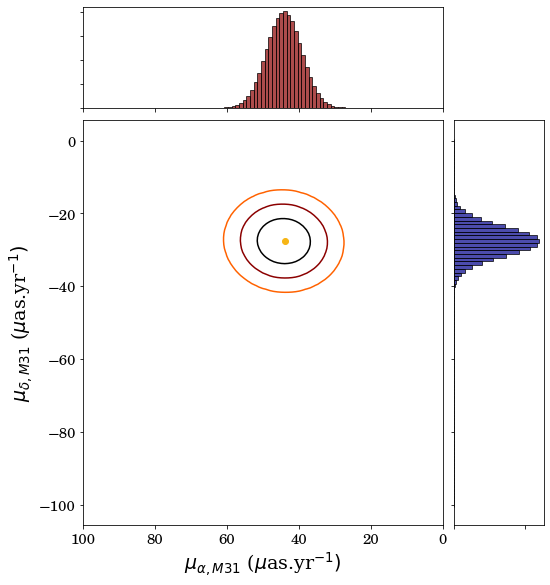

In [28]:
ObjLike = LikelihooD(99, GaiaDataBlue, ModelDataBlue, [])
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

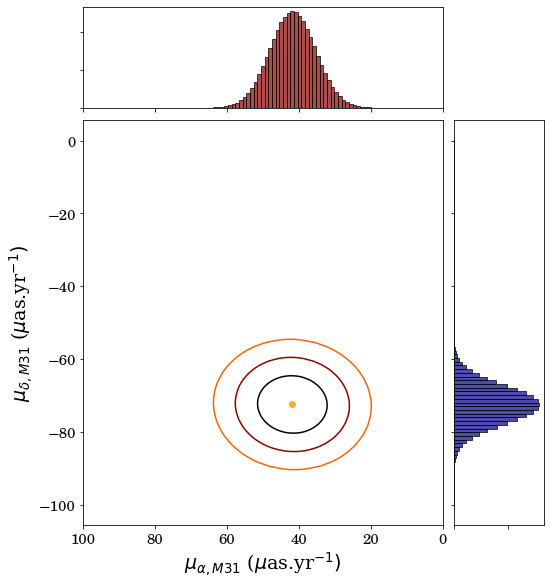

In [29]:
ObjLike = LikelihooD(99, GaiaDataRed, ModelDataRed, [])
ObjLike.Execute()
ObjLike.Plot()

# Contamination 

In [58]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData, MockData):
        self.NbModels = NbModels
    
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        self.corr             = GaiaData[6]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]
        
        if len(MockData) != 0:
            self.mu_ra_gaia  = MockData[0]
            self.mu_dec_gaia = MockData[1]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_dec_M31), len(self.pm_ra_M31)))
        for i in range(len(self.pm_dec_M31)):
            for j in range(len(self.pm_ra_M31)):
                for k in range(len(self.mu_ra_gaia)):
                    self.LikelihoodList[j,i] += (1 - 0.027)*LikelihoodCFunctionCorr(self.pm_ra_M31[i], self.pm_dec_M31[j], 
                                                                    self.mu_ra_model[k], self.mu_dec_model[k],
                                                                    self.mu_ra_sig_gaia[k], self.mu_dec_sig_gaia[k], 
                                                                    self.mu_ra_gaia[k], self.mu_dec_gaia[k], self.corr[k])
                    
                    self.LikelihoodList[j,i] += 0.027*LikelihoodCFunctionCorr(self.pm_ra_M31[i], self.pm_dec_M31[j], 
                                                                    0.00015, -0.00269,
                                                                    self.mu_ra_sig_gaia[k], self.mu_dec_sig_gaia[k], 
                                                                    self.mu_ra_gaia[k], self.mu_dec_gaia[k], self.corr[k])

        self.Renormalisation()  
        
        self.OneDimGaussian()
        
        return self.ra_max, self.dec_max
                
    def FreeParameters(self):
        self.pm_ra_M31  = np.linspace(0., 0.1, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.1, 0., self.NbModels)
        
        self.space = (self.pm_ra_M31[-1] - self.pm_ra_M31[-2])
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_ra_M31)):
            for j in range(len(self.pm_dec_M31)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_M31[dec_max], self.pm_dec_M31[ra_max]
             
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
             
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelleft=False, labelsize=0, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=0, labelbottom=False)
                       
            ax.contour([x * 1000 for x in self.pm_ra_M31], [x * 1000 for x in self.pm_dec_M31], self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#ff6200', 'darkred', 'black'])
            ax.scatter(self.ra_max*1000, self.dec_max*1000, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_M31)):
                self.x_bins.append(self.pm_ra_M31[i] - self.space/2)
            for i in range(len(self.pm_ra_M31)):
                self.y_bins.append(self.pm_dec_M31[i] - self.space/2)

            #Plot of the RA histogram
            colors = self.y_gaus / np.max(self.y_gaus)
            ax_histx.bar([x * 1000 for x in self.x_bins], self.y_gaus, width=self.space*1000, align='edge', 
                         edgecolor='black', color='darkred', alpha=0.7)
            ax_histx.set_yticklabels([])
            self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            colors = self.x_gaus / np.max(self.x_gaus)
            ax_histy.barh([x * 1000 for x in self.y_bins], self.x_gaus, height=self.space*1000, align='edge', 
                          edgecolor='black', color='darkblue', alpha=0.7)
            ax_histy.set_xticklabels([])
            self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(8, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 2)) + "\pm" + str(
            round(abs(self.popt_ra[2])*1000, 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 2)) + "\pm" + str(
            round(abs(self.popt_dec[2])*1000, 1))  + r"\ \mu as/yr"))

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

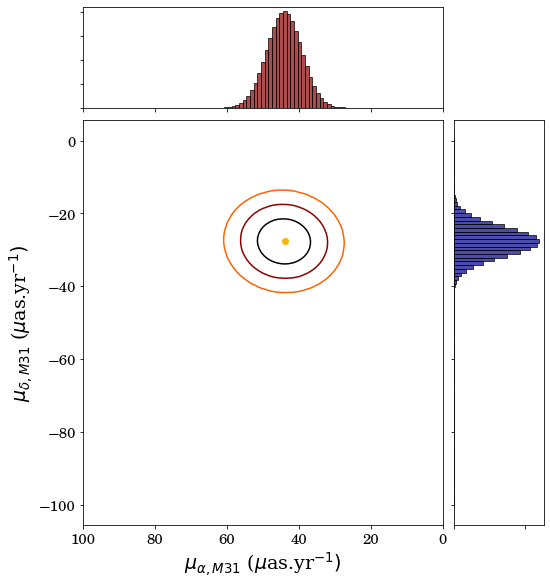

In [59]:
ObjLike = LikelihooD(99, GaiaDataBlue, ModelDataBlue, [])
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

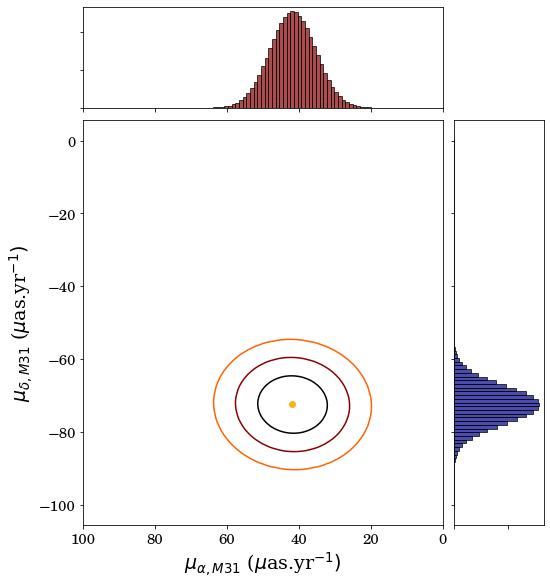

In [60]:
ObjLike = LikelihooD(99, GaiaDataRed, ModelDataRed, [])
ObjLike.Execute()
ObjLike.Plot()

In [43]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [ ]:
%%cython
from math import pi

cdef extern from "math.h":
    double log(double)

cdef double my_log(double x):
    return log(x)

def LikelihoodCFunction(double pm_ra_M31, double pm_dec_M31, double mu_ra_model, double mu_dec_model,
                        double mu_ra_sig_gaia, double mu_dec_sig_gaia, double mu_ra_gaia, double mu_dec_gaia):
    cdef double GaussianCenter_ra, GaussianCenter_dec, PreFactor, ExpRa, ExpDec
    
    GaussianCenter_ra  = pm_ra_M31 + mu_ra_model
    GaussianCenter_dec = pm_dec_M31 + mu_dec_model

    PreFactor = 1/(2*pi*mu_ra_sig_gaia*mu_dec_sig_gaia)    
    ExpRa  = -0.5*((mu_ra_gaia - GaussianCenter_ra)/(mu_ra_sig_gaia))**2
    ExpDec = -0.5*((mu_dec_gaia - GaussianCenter_dec)/(mu_dec_sig_gaia))**2
    
    return my_log(PreFactor) + ExpRa + ExpDec #exp to come back to the L and not ln(L)

def LikelihoodCFunctionCorr(double pm_ra_M31, double pm_dec_M31, double mu_ra_model, double mu_dec_model,
                        double mu_ra_sig_gaia, double mu_dec_sig_gaia, double mu_ra_gaia, 
                        double mu_dec_gaia, double pm_corr):
    cdef double GaussianCenter_ra, GaussianCenter_dec, PreFactor, ExpRa, ExpDec, ExpCor
    
    GaussianCenter_ra  = pm_ra_M31 + mu_ra_model
    GaussianCenter_dec = pm_dec_M31 + mu_dec_model

    PreFactor = 1/(2*pi*mu_ra_sig_gaia*mu_dec_sig_gaia*(1 - pm_corr**2)**(0.5))    
    ExpRa  = -(1/(2*(1 - pm_corr**2)))*((mu_ra_gaia - GaussianCenter_ra)/(mu_ra_sig_gaia))**2
    ExpDec = -(1/(2*(1 - pm_corr**2)))*((mu_dec_gaia - GaussianCenter_dec)/(mu_dec_sig_gaia))**2
    ExpCor =  (1/(2*(1 - pm_corr**2)))*((2*pm_corr*(mu_ra_gaia - GaussianCenter_ra)*(
              mu_dec_gaia - GaussianCenter_dec))/(mu_ra_sig_gaia*mu_dec_sig_gaia))
    
    return my_log(PreFactor) + ExpRa + ExpDec + ExpCor #exp to come back to the L and not ln(L)